In [509]:
import pandas as pd
import matplotlib.pyplot as plt
from tdmsdata import TdmsData
import numpy as np
from scipy.optimize import curve_fit
from statistics import mean
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d

In [510]:
# inputs
file = '20231118_1753_Sn_60s_1kHz_1160nm.tdms'
channel = 1

In [519]:
# raw data to dataset (run once)
TDMS = TdmsData(''.join(['/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/{}'.format(file)]))

raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)])) # 2D np array

dataset = pd.DataFrame({'Cycle': raw_data[:, 0], 'Time(sec)': raw_data[:, 1], 
                        'Wavelength (nm)': raw_data[:, 2], 'Dump current (nA)': raw_data[:, -1]}) # raw data in pd dataframe 

In [527]:
wavelengths = dataset['Wavelength (nm)']
cycle = dataset['Cycle']
no_of_cycles = int(dataset["Cycle"].max())
cycles = np.linspace(1,no_of_cycles, no_of_cycles)
time = dataset["Time(sec)"]
current = dataset['Dump current (nA)']

In [572]:
# dataset[dataset['Cycle'] == 1.0]

In [586]:
all_normalized_data = []

for x in cycles:
    separated = dataset.loc[dataset['Cycle']==x]
    sep_current = separated['Dump current (nA)']
    sep_time = separated['Time(sec)']

    single_current = separated.iloc[-1]['Dump current (nA)']

    # Define the number of bins (same as in your histogram)
    n_bins = 200

    # Create bins using `pd.cut`
    bin_edges = pd.cut(sep_time, bins=n_bins, right=False)

    # Get counts for each bin
    binned_data = sep_time.groupby(bin_edges, observed=False).size()

    normalized_counts = binned_data / single_current

    normalized_df = pd.DataFrame({
        'Bin_Range': binned_data.index.astype(str),  # Convert bin edges to strings for better display
        'Normalized_Counts': normalized_counts
    })

    # Optionally add cycle information to the DataFrame
    normalized_df['Cycle'] = x

    # Append the DataFrame to the list for future use or concatenation
    all_normalized_data.append(normalized_df)

    # Print or save the DataFrame for each cycle
    # print(f"Cycle {x} Normalized Data:\n", normalized_df, "\n")

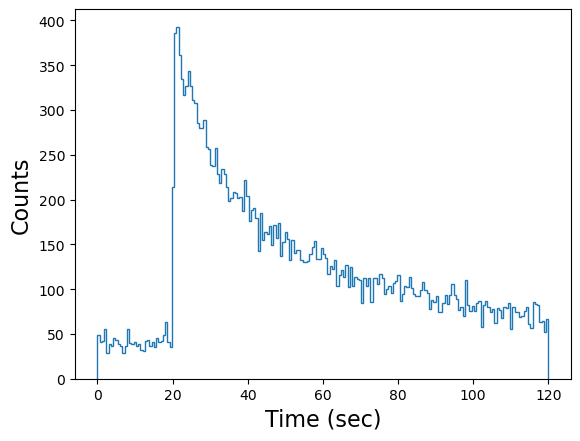

In [571]:
fig, wl_hist = plt.subplots(1, 1)

(counts, bins, vals) = wl_hist.hist(
    time,
    bins=200,
    # range=(20,300),
    log = False, 
    histtype='step',
)

plt.xlabel('Time (sec)', size = 16)
plt.ylabel('Counts', size = 16)

# plt.gca().set_yticklabels([])
# plt.gca().tick_params(axis='x', labelsize=14)
plt.show()

In [538]:
cycle_test = dataset[dataset['Cycle'] == 1.0]
current_test = cycle_test.iloc[-1]['Dump current (nA)']

1.781

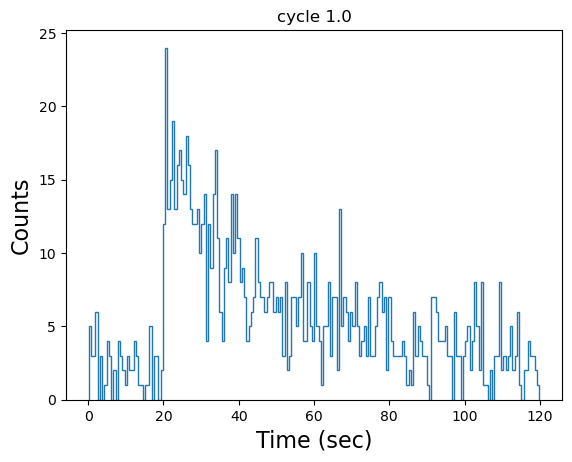

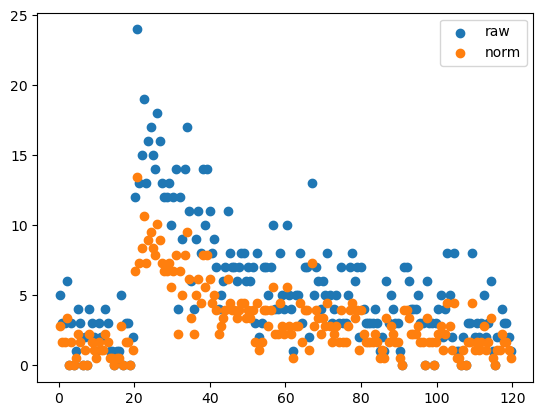

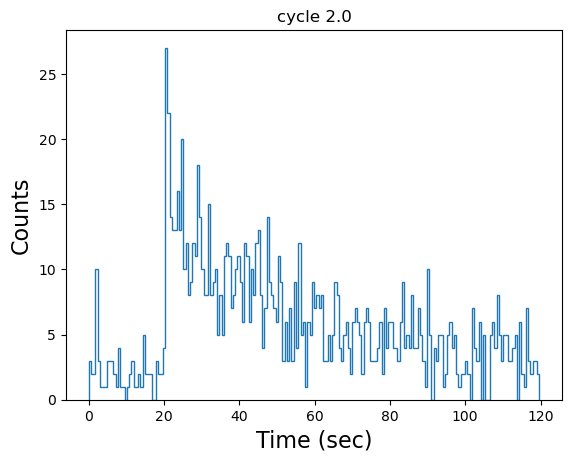

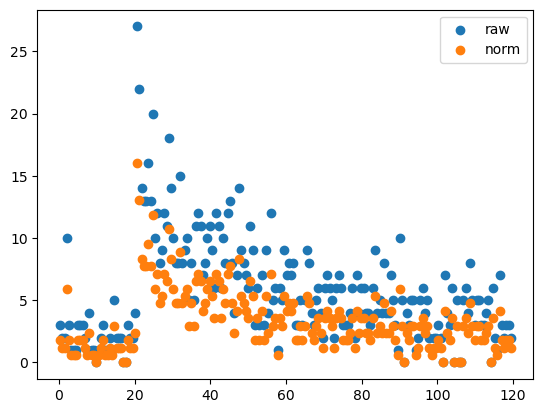

In [570]:
# test for normalization 
for x in cycles[:2]:
    separated = dataset.loc[dataset['Cycle']==x]
    sep_current = separated['Dump current (nA)']
    sep_time = separated['Time(sec)']

    single_current = separated.iloc[-1]['Dump current (nA)']

    fig, wl_hist = plt.subplots(1, 1)

    (counts, bins, vals) = wl_hist.hist(
        sep_time,
        bins=200,
        # range=(20,300),
        log = False, 
        histtype='step',
    )

    plt.xlabel('Time (sec)', size = 16)
    plt.ylabel('Counts', size = 16)
    plt.title(f'cycle {x}')
    # plt.gca().set_yticklabels([])
    # plt.gca().tick_params(axis='x', labelsize=14)
    plt.show()

    normalized_counts = counts / single_current

    # Calculate bin centers for plotting
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.scatter(bin_centers, counts, label = 'raw')
    plt.scatter(bin_centers, normalized_counts, label = 'norm')
    plt.legend()
    plt.show()


In [551]:
# Function to calculate bin values up to a certain x
def calculate_bin_average(up_to_x, bin_edges, counts):
    # Find the index of the bin corresponding to 'up_to_x'
    bin_index = np.digitize(up_to_x, bin_edges) - 1  # -1 for zero-based index

    if 0 <= bin_index < len(counts):
        # Sum the counts for all bins up to and including the specified bin
        relevant_counts = counts[:bin_index + 1]
        total_counts = np.sum(relevant_counts)
        bkg = np.mean(relevant_counts)

    return bkg 


calculate_bin_average(20, bins, counts)


46.05882352941177

558.4709378063733
393.0


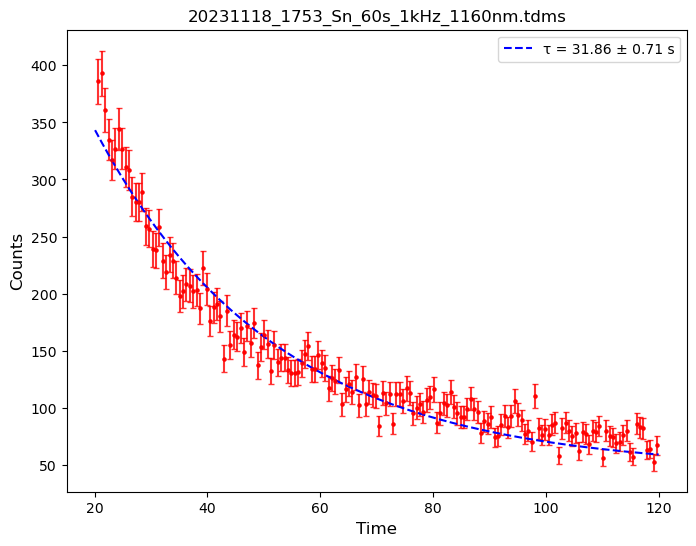

In [554]:
def exp_decay(t, A, tau):
    bkg = calculate_bin_average(20, bins, counts)
    return A * np.exp(-t / tau) + bkg 

x_min, x_max = 20.1, 120  

errors = np.sqrt(counts)

# Subset the data to include only the specified x-range
mask = (bin_centers >= x_min) & (bin_centers <= x_max)
bin_centers_subset = bin_centers[mask]
counts_subset = counts[mask]
errors_subset = errors[mask]  

# Fit the exponential decay to the subset data
popt, pcov = curve_fit(exp_decay, bin_centers_subset, counts_subset, p0=(max(counts), 100.0))

# Extract the optimized parameters
A_fit, tau_fit = popt
A_err, tau_err = np.sqrt(np.diag(pcov))

# Plot the Scatter Plot and Fitted Curve
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the scatter plot for the subset data
ax.errorbar(bin_centers_subset, counts_subset, yerr=errors_subset, fmt='o', color='red', 
            markersize=2, alpha=0.8, capsize=2)

ax.scatter(bin_centers_subset, counts_subset, color='red', s=5, alpha=0.7)

# Plot the fitted exponential decay curve within the x-range
t_fit = np.linspace(x_min, x_max, 1000)  # Time points for the fitted curve within the specified range
ax.plot(t_fit, exp_decay(t_fit, A_fit, tau_fit), 'b--', label=f'τ = {tau_fit:.2f} ± {tau_err:.2f} s')
print(A_fit)
print(max(counts))

# Labels and formatting
ax.set_title(f'{file}')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.legend()

plt.show()